# 导入函数库

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds # 这个是指Tensorflow Datasets
import matplotlib.pyplot as plt

# 如果出现显存不够的错误,把这个代码加上

In [2]:
# 加入下面这个代码片段主要是因为TF2.0对RTX20系列显卡支持不是很好,容易爆显存,所以设置成用多少占多少显存,而不是一次性全占了(默认)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 定义网络结构

## 一些参数设置

In [3]:
layers = tf.keras.layers
models = tf.keras.models

IMG_SIZE = 150
BATCH_SIZE = 4 * 1
SHUFFLE_BUFFER_SIZE = 24 * 1
DATASET_NAME = 'beans'
SPLIT = ['test', 'train', 'validation']
DATA_DIR = './tensorflow_datasets'
LEARNING_RATE = 1e-6
EPOCHS = 5
CLASSES = 3
weights_path = './models/vgg16.h5'

## 定义VGG16模型用于植物病例分类

In [4]:
def VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), # 原始图片是500x500x3
         classes=CLASSES):
    img_input = layers.Input(shape=input_shape)  # 输入节点
    
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', name='fc1')(x)
    x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    
    inputs = img_input  # inputs是输入节点
    outputs = x # x是输出节点
    model = models.Model(inputs, outputs , name='vgg16')  # 生成一个Model, 需要指定输入和输出
    
    model.load_weights(weights_path, by_name=True)  # 注意by_name参数很有用，把layer和layer name对应上了
    
    return model

## 声明一个VGG16模型实例

In [5]:
model = VGG16()

## 模型训练日志记录

In [6]:
log_dir = './logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## 进行数据增强

In [7]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE+32, IMG_SIZE+32)
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3]) # Random crop back to 224x224
    return image, label

def augment(image, label):
    image, label = convert(image, label)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3) # Random brightness
    return image, label

## 数据读取并预处理

In [8]:
# 此处使用tfds的方式构建data pipeline
(raw_test, raw_train, raw_validation), metadata = tfds.load(
    DATASET_NAME, # 数据集名称，这个是caltech101分类数据集，共102个类别(包含background类别)
    split=SPLIT, # 这里的raw_test和split的'test'对应，raw_train和split的'train'对应
    with_info=True, # 这个参数和metadata对应
    as_supervised=True, # 这个参数的作用是返回tuple形式的(input, label),举个例子，raw_test=tuple(input, label)
    data_dir=DATA_DIR
)


# 可以体验下这里是否加prefetch(tf.data.experimental.AUTOTUNE)和cache()的区别，对训练速度，以及CPU负载有影响
train_batches = raw_train.shuffle(SHUFFLE_BUFFER_SIZE).map(augment).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = raw_test.map(convert).batch(BATCH_SIZE)

## 进行模型训练

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.fit(
    train_batches,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback]
)

Epoch 1/5
259/259 [==============================] - 10s 39ms/step - loss: 0.5861 - accuracy: 0.9681
Epoch 2/5
259/259 [==============================] - 10s 37ms/step - loss: 0.5827 - accuracy: 0.9700
Epoch 3/5
259/259 [==============================] - 9s 35ms/step - loss: 0.5795 - accuracy: 0.9739
Epoch 4/5
259/259 [==============================] - 9s 35ms/step - loss: 0.5792 - accuracy: 0.9749
Epoch 5/5
259/259 [==============================] - 9s 35ms/step - loss: 0.5766 - accuracy: 0.9758


## 模型训练后预测展示

angular_leaf_spot
bean_rust
bean_rust
bean_rust
healthy


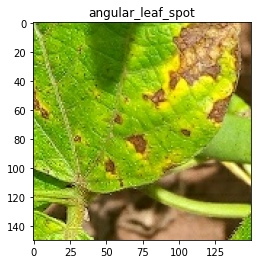

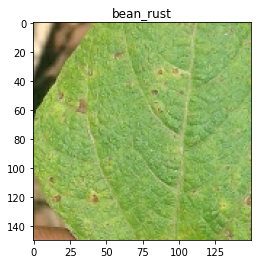

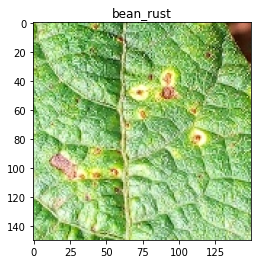

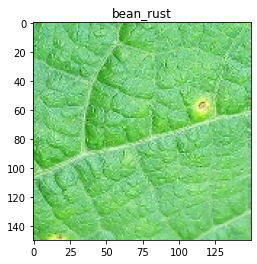

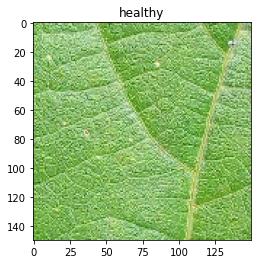

In [10]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_test.take(5):
    image, label = convert(image, label)
    predict = np.argmax(model.predict(np.expand_dims(image, axis=0)))
    print(get_label_name(predict))
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

## Baseline的test acc，并保存模型

In [11]:
_, baseline_model_accuracy = model.evaluate(test_batches, verbose=1)
print('Baseline test accuracy: ', baseline_model_accuracy)

keras_file = './test.h5'
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to: ', keras_file)

32/32 [==============================] - 0s 11ms/step - loss: 0.6142 - accuracy: 0.9375
Baseline test accuracy:  0.9375
Saved baseline model to:  ./test.h5
